<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Kaggle_Dumps/CommonLit_Readability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai -q --upgrade

     |████████████████████████████████| 194kB 7.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 


In [2]:
# Loading in the data paths from the drive 
train_path = 'train.csv'
test_path = 'test.csv'
sample_sub_path = 'sample_submission.csv'

# Importing the needed packages 
import fastai 
print(fastai.__version__)

from fastai.vision.all import * 
from fastai import  * 
import pandas as pd 
import matplotlib.pyplot as plt
from fastai.text.all import * 


2.4


In [3]:
# Reading in the train and test data using pandas 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThe...",-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.\nAt last, however, when the meal was nearly over, she smiled at her little daughter, and said, ""All right, Dolly, you may go.""\n""Oh, mother!"" Dolly cried, overwhelmed with sudden delight. ""Really?\nOh, I am so glad! Are you sure you're willing?""\n""I've persuaded myself to be willing, against my will,"" returned Mrs. Fayre, whimsically...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the ground. Tennis was again possible and a great game was in progress on the court at Pine Laurel. Patty and Roger were playing against Elise and Sam Blaney, and the pairs were well matched.\nBut the long-contested victory finally went against Patty, and she laughingly accepted defeat.\n""Only because Patty's not quite back on her game yet,"" Roger defended; ""this child has been on the sick list, you know, Sam, and she isn't up to her own mark.""\n""We...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, pears, and apples, which bore the whole year round. For the rich south-west wind fed them, till pear grew ripe on pear, fig on fig, and grape on grape, all the winter and the spring. And at the farther end gay flower-beds bloomed through all seasons of the year; and two fair fountains rose, and ran, one through the garden grounds, and one beneath the palace gate, to water all the town. Such noble gifts the heavens had given to Alcinous the wise.\n...",-1.054013,0.450007
4,37c1b32fb,NaN,NaN,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one was a Middle-sized Bear, and the other was a Great, Huge Bear. They had each a pot for their porridge; a little pot for the Little, Small, Wee Bear; and a middle-sized pot for the Middle Bear; and a great pot for the Great, Huge Bear. And they had each a chair to sit in; a little chair for the Little, Small, Wee Bear; and a middle-sized chair for the Middle Bear; and a great chair for the Great, Huge Bear. And they had each a bed to sleep in; a li...",0.247197,0.510845


In [4]:
dls_lm = TextDataLoaders.from_df(df =train_df , 
                              path = train_path  , is_lm = True  , 
                              text_col = 'excerpt')
dls_lm.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj our xxmaj ned is a brave little fellow about eight years old . xxmaj he is full of fun , and loves to play out of doors in all kinds of weather . xxmaj but what little boy can be merry when he has a raging xxunk ! xxmaj ned bore it like a hero ; but he had to give up at last , and he was glad to","xxmaj our xxmaj ned is a brave little fellow about eight years old . xxmaj he is full of fun , and loves to play out of doors in all kinds of weather . xxmaj but what little boy can be merry when he has a raging xxunk ! xxmaj ned bore it like a hero ; but he had to give up at last , and he was glad to take"
1,"was sick and could not play . xxmaj andiswa begged the coach , "" please , let me play . "" xxmaj the coach was not sure what to do . xxmaj then he decided that xxmaj andiswa could join the team . xxmaj the game was tough . xxmaj nobody had scored a goal by half time . xxmaj during the second half of the match , xxmaj andiswa got the","sick and could not play . xxmaj andiswa begged the coach , "" please , let me play . "" xxmaj the coach was not sure what to do . xxmaj then he decided that xxmaj andiswa could join the team . xxmaj the game was tough . xxmaj nobody had scored a goal by half time . xxmaj during the second half of the match , xxmaj andiswa got the ball"
2,"on week - days . \n xxmaj on the purchase of these few things he spent the small xxunk that came to him every year . xxmaj he had in his house a woman - servant about forty years old , a niece not yet twenty , and a lad that served him both in field and at home , and could saddle his horse or manage a xxunk - hook .","week - days . \n xxmaj on the purchase of these few things he spent the small xxunk that came to him every year . xxmaj he had in his house a woman - servant about forty years old , a niece not yet twenty , and a lad that served him both in field and at home , and could saddle his horse or manage a xxunk - hook . xxbos"
3,"very difficult , and perhaps a very dangerous , thing ; but that he would pray for him , and perhaps he might be able to do it ; only he warned the king both against the dangers of his xxunk and against the curiosity which prompted him to ask this thing . xxmaj however , the king was not to be turned from his purpose , and he promised the fakeer","difficult , and perhaps a very dangerous , thing ; but that he would pray for him , and perhaps he might be able to do it ; only he warned the king both against the dangers of his xxunk and against the curiosity which prompted him to ask this thing . xxmaj however , the king was not to be turned from his purpose , and he promised the fakeer always"
4,", suggested itself to many that this heat of the ingot ought to be utilized , and as a matter of fact , there have been , at various times and in different places , attempts made to do so ; but hitherto all such attempts have proved failures , and a kind of settled conviction has been established in the steel trade that the theory could not possibly be carried out","suggested itself to many that this heat of the ingot ought to be utilized , and as a matter of fact , there have been , at various times and in different places , attempts made to do so ; but hitherto all such attempts have proved failures , and a kind of settled conviction has been established in the steel trade that the theory could not possibly be carried out in"
5,"become of the torch . "" xxbos xxmaj environmental science is an xxunk academic field that xxunk physical , biological and information sciences ( including xxunk , biology , physics , chemistry , xxunk , xxunk , xxunk , xxunk , soil science , geology , atmospheric science , and xxunk ) to the study of the environment , and the solution of environmental problems . xxmaj environmental science emerged from the","of the torch . "" xxbos xxmaj environmental science is an xxunk academic field that xxunk physical , biological and information sciences ( including xxunk , biology , physics , che

In [5]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path='models/', wd=0.1).to_fp16()

In [6]:
learn.fit_one_cycle(1 , 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.379592,4.053102,0.285939,57.575783,00:18


In [7]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.203844,3.887954,0.298766,48.810917,00:20
1,4.054334,3.813557,0.297766,45.311310,00:20
2,3.867989,3.792953,0.299479,44.387295,00:20
3,3.692492,3.796233,0.299425,44.533108,00:20
4,3.505363,3.815057,0.298177,45.379356,00:20
5,3.339036,3.829093,0.299425,46.020756,00:20
6,3.174762,3.847179,0.298441,46.860668,00:20
7,3.040934,3.866165,0.299177,47.758888,00:20
8,2.956331,3.884027,0.297976,48.619602,00:20
9,2.899007,3.887955,0.297681,48.810986,00:20


In [8]:
learn.save_encoder('finetuned')

In [9]:
dls_reg = TextDataLoaders.from_df(df =train_df , 
                              path = train_path , 
                              text_col = 'excerpt' , 
                              label_col = 'target' , 
                              y_block = RegressionBlock , 
                              seq_len = 72 , 
                              bs = 64 , 
                              valid_pct = 0.1  , 
                              text_vocab = dls_lm.vocab)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
learn = text_classifier_learner(dls_reg , AWD_LSTM , drop_mult= 0.4 , metrics= [mae , rmse , mse] , path= 'models/')
learn = learn.load_encoder('finetuned')

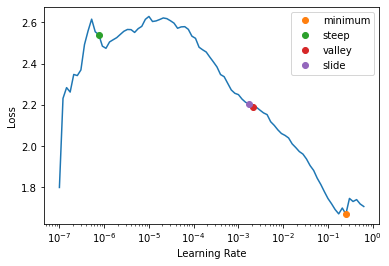

In [16]:
lrs = learn.lr_find(suggest_funcs=(minimum , steep , valley , slide))

In [17]:
learn.fit_one_cycle(1 , lrs.valley.item())

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,1.425073,1.508705,1.080497,1.228293,1.508705,00:10


In [19]:
learn.freeze_to(-2)

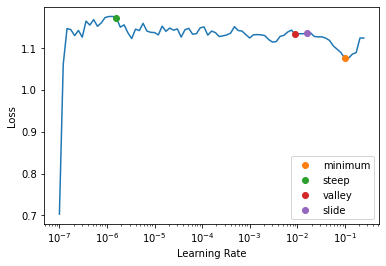

In [20]:
lrs = learn.lr_find(suggest_funcs=(minimum , steep , valley , slide))

In [22]:
learn.fit_one_cycle(3 , lr_max = slice(lrs.valley.item() , lrs.slide.item()))

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,0.866678,0.586662,0.609773,0.765939,0.586662,00:12
1,0.590400,0.965613,0.831699,0.982656,0.965613,00:12
2,0.437281,0.362868,0.484470,0.602385,0.362868,00:12


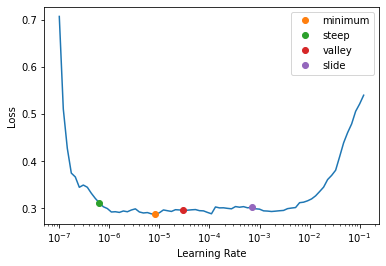

In [23]:
learn.freeze_to(-4)
lrs = learn.lr_find(suggest_funcs=(minimum , steep , valley , slide))

In [24]:
learn.fit_one_cycle(4 , slice(lrs.valley.item() ,lrs.slide.item() ))

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,0.289477,0.350497,0.475550,0.592028,0.350497,00:25
1,0.277946,0.373476,0.497378,0.611127,0.373476,00:26
2,0.250884,0.353100,0.480246,0.594222,0.353100,00:25
3,0.237879,0.362135,0.488604,0.601777,0.362135,00:25


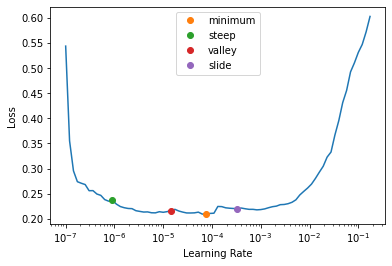

In [25]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum , steep , valley , slide))

In [26]:
learn.fit_one_cycle(10, slice(lrs.valley.item() , lrs.slide.item()))

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,0.216524,0.384487,0.504591,0.620070,0.384487,00:25
1,0.216323,0.370195,0.496418,0.608437,0.370195,00:26
2,0.217193,0.388067,0.508994,0.622950,0.388067,00:25
3,0.209936,0.377183,0.501087,0.614153,0.377183,00:25
4,0.197179,0.370359,0.496214,0.608571,0.370359,00:25
5,0.183453,0.399698,0.517586,0.632217,0.399698,00:25
6,0.179719,0.371541,0.494212,0.609542,0.371541,00:25
7,0.171166,0.382419,0.504820,0.618401,0.382419,00:25
8,0.162993,0.372053,0.495687,0.609961,0.372053,00:25
9,0.160282,0.372133,0.496219,0.610027,0.372133,00:25


In [39]:
dls = TextDataLoaders.from_df(df =train_df , 
                              path = train_path , 
                              text_col = 'excerpt' , 
                              label_col = 'target' , 
                              y_block = RegressionBlock , 
                              seq_len = 72 , 
                              bs = 64 , 
                              valid_pct = 0.1 )

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [40]:
dls.show_batch()


,text,text_
0,"xxbos xxmaj in those days all cloth had to be made at home . xxmaj aunt xxmaj xxunk , xxmaj aunt xxmaj xxunk , and xxmaj aunt xxmaj dilsey were kept busy spinning and weaving to make clothes for the whole plantation . \n xxmaj one day xxmaj mary 's mother said , "" aunt xxmaj dilsey , xxmaj mary needs a new dress , and i want you to weave some cloth at once . xxmaj can you weave some very fine cloth ? "" \n "" yes , ma'am , "" said xxmaj aunt xxmaj dilsey . "" i have some cotton xxmaj i 've been saving to make her a dress . "" \n xxmaj aunt xxmaj dilsey got out the cards and carded the cotton smooth and fine . xxmaj then she fastened a roll of this cotton to the spindle and sent the wheel xxunk",0.08876363933086395
1,"xxbos xxmaj mother xxmaj goat passes by . "" will you go to the fair with me ? "" she asks xxmaj mother xxmaj hen . \n "" i 'm busy with my eggs , "" xxmaj mother xxmaj hen answers . xxmaj one , two , three , four , five , six . \n xxmaj six round eggs ! xxmaj mother xxmaj pig passes by . "" will you go to the fair with me ? "" she asks . "" i 'm busy with my eggs , "" answers xxmaj mother xxmaj hen . xxmaj one , two , three , four , five , six . xxmaj six round eggs ! xxmaj mother xxmaj cow passes by . "" will you go to the fair with me ? "" she asks xxmaj mother xxmaj hen . "" i 'm busy with my eggs , "" answers",0.6820314526557922
2,"xxbos xxmaj when xxmaj papa came home , xxmaj sima was nursing xxmaj xxunk . "" what are you doing ? "" asked xxmaj papa . "" i 'm being a nurse , "" said xxmaj sima . "" will you play with me ? "" "" yes . xxmaj but we will go to the park and play soccer , "" said xxmaj papa . xxmaj his friends saw xxmaj sima and xxmaj papa playing soccer . xxmaj they joined in . xxmaj sima and xxmaj papa often play soccer now . xxmaj but they still have n't played with dolls . xxmaj one day , xxmaj sima was playing hospital - hospital with his dolls . xxmaj he heard xxmaj mama shout . "" sima ! xxmaj run ! xxmaj papa is waiting to play with you at the park . "" "" why on earth are you",-0.15450337529182434
3,"xxbos a baby elephant was born . xxmaj she was very curious . xxmaj she had a question for every animal . xxmaj she was curious about xxmaj giraffe . "" why do you have a long neck ? "" she asked . xxmaj she was curious about xxmaj rhino . "" why does your horn have a sharp point ? "" she asked . xxmaj she was very curious about xxmaj crocodile . "" what do crocodiles eat for dinner ? "" she asked . xxmaj clever xxmaj crow quickly said , "" follow me to the river . xxmaj there you will see what crocodiles eat for dinner . "" xxmaj so , xxmaj baby xxmaj elephant followed xxmaj crow to the river . xxmaj she pushed through the reeds and stood on the bank . xxmaj she looked into the water . xxmaj where was xxmaj crocodile",1.2942910194396973
4,"xxbos xxmaj there was an old lady with a xxunk . \n a fairy flew by and stopped to ask why the old lady was crying . \n "" i have a terrible xxunk , "" she wept . "" can you help me ? "" \n xxmaj the fairy said "" no , i ca n't help you . xxmaj i 'm xxmaj sibusiso , the evil fairy . i only do bad things . "" \n "" then please , go away , "" said the woman . \n xxmaj with an evil xxunk , xxmaj sibusiso disappeared . ( he became invisible . ) \n xxmaj the old lady rubbed her stomach . xxmaj before long , another fairy came along . \n xxmaj this fairy , named xxmaj khumo , also asked what was wrong . \n "" my stomach is sore ! "" moaned the",0.7001174688339233
5,"xxbos xxmaj once upon a time , xxmaj sly xxmaj jackal woke up early in the morning . xxmaj he was very hungry . xxmaj his xxunk gave a big growl . xxup xxunk xxrep 5 r ! xxmaj he jumped up and went searching for food . \n xxmaj he wandered around the forest for hours without getting any food . xxmaj the sun was very hot . xxmaj sly xxmaj jackal could barely see in front of him . xxmaj all he could think of was his hunger xxunk . \n "" xxunk xxrep 4 u ! "" xxmaj sly xxmaj jackal let o

In [29]:
# Creating a learner 
learn = text_classifier_learner(dls , AWD_LSTM , 
                                metrics = [mae , mse , rmse] ,  )
learn.path = Path("./")

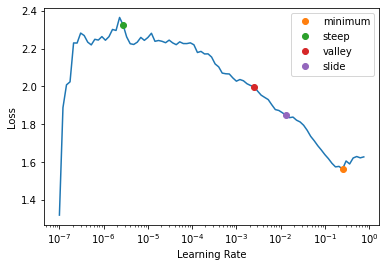

In [30]:
# Finding the learning rate 
lrs = learn.lr_find(suggest_funcs= (minimum , steep , valley , slide))

In [31]:
learn.fit_one_cycle(3 , lr_max= slice(lrs.valley.item() , lrs.slide.item()) , wd = 0.2)

epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,1.178578,0.478402,0.549795,0.478402,0.691666,00:10
1,0.727254,0.465336,0.555127,0.465336,0.682156,00:10
2,0.553714,0.417914,0.523535,0.417914,0.646463,00:10


In [32]:
learn.freeze_to(-3)
learn.fit_one_cycle(1 , slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,0.483318,0.406094,0.523852,0.406094,0.637255,00:19


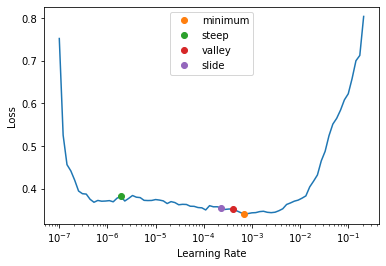

In [33]:
learn.unfreeze()
# Finding the learning rate 
lrs = learn.lr_find(suggest_funcs= (minimum , steep , valley , slide))

In [35]:
lrs.minimum

6.918309954926372e-05

In [36]:
learn.fit_one_cycle(10 , slice(lrs.slide.item() , lrs.minimum / 10))

epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,0.342436,0.395882,0.516306,0.395882,0.629191,00:25
1,0.336477,0.413570,0.523000,0.413570,0.643094,00:26
2,0.331490,0.371794,0.496305,0.371794,0.609749,00:25
3,0.316826,0.364569,0.490667,0.364569,0.603796,00:25
4,0.301011,0.377576,0.499137,0.377576,0.614472,00:25
5,0.282682,0.352555,0.483371,0.352555,0.593764,00:25
6,0.270977,0.374671,0.494876,0.374671,0.612104,00:25
7,0.257157,0.353340,0.483598,0.353340,0.594424,00:25
8,0.249367,0.377144,0.497528,0.377144,0.614120,00:25
9,0.245032,0.358226,0.486969,0.358226,0.598520,00:25


In [ ]:
l

In [12]:
learn.fine_tune(10 , lrs.valley.item() , freeze_epochs= 3)

epoch,train_loss,valid_loss,mae,mse,time
0,1.796275,1.300446,0.950775,1.300446,00:09
1,1.457843,1.107238,0.863026,1.107238,00:09
2,1.092516,0.738223,0.683613,0.738223,00:09


epoch,train_loss,valid_loss,mae,mse,time
0,0.542125,0.460165,0.534367,0.460165,00:23
1,0.501634,0.426535,0.515573,0.426535,00:24
2,0.469439,0.444679,0.532407,0.444679,00:24
3,0.428984,0.425806,0.511081,0.425806,00:24
4,0.371376,0.414132,0.515147,0.414132,00:24
5,0.333870,0.382929,0.488455,0.382929,00:24
6,0.299076,0.387256,0.500025,0.387256,00:24
7,0.275404,0.410868,0.512371,0.410868,00:24
8,0.250903,0.420262,0.514252,0.420262,00:24
9,0.238151,0.407881,0.506420,0.407881,00:24


In [38]:
learn.path = Path("./")
learn.export()